# Regression Workshop

* 가락시장의 고구마에 대한 일일 특 등급 가격을 예측하고자 합니다.  
* 일별 농산물 가격정보와 일별 입고정보만을 가지고 데이터프레임을 구성하고 예측을 시도해 봅시다.


## 00 환경준비

### 01.Import

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### 02.Data Loading

In [6]:
g_in = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/garak_market_in.CSV')
g_price = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/garak_market_price.CSV')

g_price['Date'] = pd.to_datetime(g_price['Date'], format='%Y%m%d')
g_in['Date'] = pd.to_datetime(g_in['Date'], format='%Y%m%d')

### 가설수립
* 고구마 가격에 영향을 주는 요소가 무엇일까요?
* 적어도 3가지 적어 봅시다.

In [7]:
g_price.head()

,Date,ProductID,Grade,KG,ProductName,Price
0,2019-01-03,15100,0,10,고구마,44450
1,2019-01-03,15100,1,10,고구마,34122
2,2019-01-03,15100,2,10,고구마,24459
3,2019-01-03,15100,3,10,고구마,11400
4,2019-01-03,22500,0,10,토마토,25951


In [8]:
g_in.head()

,Date,ProductID,ProductName,in_ton
0,2019-01-03,23100,무,616
1,2019-01-03,23200,당근,105
2,2019-01-03,24400,양파,879
3,2019-01-03,15100,고구마,148
4,2019-01-03,22500,토마토,181


In [16]:
g_price_new = pd.concat([g_price, g_in[["in_ton"]]], axis=1)

In [17]:
g_price_new.head()

,Date,ProductID,Grade,KG,ProductName,Price,in_ton
0,2019-01-03,15100,0,10,고구마,44450,616.0
1,2019-01-03,15100,1,10,고구마,34122,105.0
2,2019-01-03,15100,2,10,고구마,24459,879.0
3,2019-01-03,15100,3,10,고구마,11400,148.0
4,2019-01-03,22500,0,10,토마토,25951,181.0


### 23.Feature Engineering

위에서 수립한 가설을 바탕으로 데이터 프레임을 만들어 봅시다.


In [19]:
# g_price 에서 고구마이면서 0등급 상품에 대해서 별도 데이터프레임으로 저장합시다.
# 날짜, Price, KG
g_price_new.head()
g_price_new_0 = g_price_new.loc[(g_price_new['Grade']==0) & (g_price_new['ProductName']=='고구마'), ['Date', 'Price', 'KG', 'in_ton']]
g_price_new_0

,Date,Price,KG,in_ton
0,2019-01-03,44450,10,616.0
35,2019-01-04,48447,10,415.0
70,2019-01-05,43085,10,423.0
105,2019-01-07,51744,10,759.0
140,2019-01-08,47523,10,189.0
...,...,...,...,...
10831,2019-12-26,33944,10,NaN
10870,2019-12-27,31748,10,NaN
10909,2019-12-28,30950,10,NaN
10948,2019-12-30,31256,10,NaN


다음의 변수를 추가합시다.

In [20]:
#unit_price  = Price / KG
#y: unit_price
g_price_new_0['Unit_Price'] = g_price_new['Price'] / g_price_new['KG']
g_price_new_0

,Date,Price,KG,in_ton,Unit_Price
0,2019-01-03,44450,10,616.0,4445.0
35,2019-01-04,48447,10,415.0,4844.7
70,2019-01-05,43085,10,423.0,4308.5
105,2019-01-07,51744,10,759.0,5174.4
140,2019-01-08,47523,10,189.0,4752.3
...,...,...,...,...,...
10831,2019-12-26,33944,10,NaN,3394.4
10870,2019-12-27,31748,10,NaN,3174.8
10909,2019-12-28,30950,10,NaN,3095.0
10948,2019-12-30,31256,10,NaN,3125.6


In [22]:
# 요일 .dt.dayofweek
 
g_price_new_0['WeekDay'] = g_price_new_0.Date.dt.dayofweek
g_price_new_0



,Date,Price,KG,in_ton,Unit_Price,WeekDay
0,2019-01-03,44450,10,616.0,4445.0,3
35,2019-01-04,48447,10,415.0,4844.7,4
70,2019-01-05,43085,10,423.0,4308.5,5
105,2019-01-07,51744,10,759.0,5174.4,0
140,2019-01-08,47523,10,189.0,4752.3,1
...,...,...,...,...,...,...
10831,2019-12-26,33944,10,NaN,3394.4,3
10870,2019-12-27,31748,10,NaN,3174.8,4
10909,2019-12-28,30950,10,NaN,3095.0,5
10948,2019-12-30,31256,10,NaN,3125.6,0


In [24]:
# 전날 가격 .shift()

g_price_new_0['Price_lag'] = g_price_new_0['Price'].shift() 



In [25]:
g_price_new_0

,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0
...,...,...,...,...,...,...,...
10831,2019-12-26,33944,10,NaN,3394.4,3,32451.0
10870,2019-12-27,31748,10,NaN,3174.8,4,33944.0
10909,2019-12-28,30950,10,NaN,3095.0,5,31748.0
10948,2019-12-30,31256,10,NaN,3125.6,0,30950.0


In [27]:
# 전날 가격 .shift()

g_price_new_0['in_ton_lag'] = g_price_new_0['in_ton'].shift() 
g_price_new_0

,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0
...,...,...,...,...,...,...,...,...
10831,2019-12-26,33944,10,NaN,3394.4,3,32451.0,NaN
10870,2019-12-27,31748,10,NaN,3174.8,4,33944.0,NaN
10909,2019-12-28,30950,10,NaN,3095.0,5,31748.0,NaN
10948,2019-12-30,31256,10,NaN,3125.6,0,30950.0,NaN


In [56]:
# 전날 입고량, .shift(), pd.merge()
g_price_new_1 = g_price_new_0[:]


위 작업 후에 나오는 결과는...
날짜, Unit_Price, Price_lag, in_ton_lag, WeekDay


이제 여러분이 가설로 뽑은 변수를 추가할 차례입니다. (최소한 2개를 추가합시다.)

In [57]:
g_price_new_1

,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0
...,...,...,...,...,...,...,...,...
10831,2019-12-26,33944,10,NaN,3394.4,3,32451.0,NaN
10870,2019-12-27,31748,10,NaN,3174.8,4,33944.0,NaN
10909,2019-12-28,30950,10,NaN,3095.0,5,31748.0,NaN
10948,2019-12-30,31256,10,NaN,3125.6,0,30950.0,NaN


In [58]:
g_price_new_1['Price_diff'] = g_price_new_1['Price_lag'] -  g_price_new_1['Price'].shift(2)
g_price_new_1.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0,NaN
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0,3997.0
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0,-5362.0
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0,8659.0


In [59]:
g_price_new_1['in_ton_diff'] = g_price_new_1['in_ton_lag'] -  g_price_new_1['in_ton'].shift(2)
g_price_new_1.head()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff,in_ton_diff
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0,NaN,NaN
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0,3997.0,-201.0
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0,-5362.0,8.0
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0,8659.0,336.0


In [60]:
g_price_new_1['Price_MA_3_lag'] = g_price_new_1['Price'].rolling(3, min_periods=1).mean().shift()
g_price_new_1.head()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff,in_ton_diff,Price_MA_3_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN,NaN,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0,NaN,NaN,44450.000000
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0,3997.0,-201.0,46448.500000
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0,-5362.0,8.0,45327.333333
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0,8659.0,336.0,47758.666667


In [61]:
g_price_new_1['in_ton_MA_3_lag'] = g_price_new_1['in_ton'].rolling(3, min_periods=1).mean().shift()
g_price_new_1.head()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff,in_ton_diff,Price_MA_3_lag,in_ton_MA_3_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN,NaN,NaN,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0,NaN,NaN,44450.000000,616.000000
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0,3997.0,-201.0,46448.500000,515.500000
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0,-5362.0,8.0,45327.333333,484.666667
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0,8659.0,336.0,47758.666667,532.333333


In [62]:
g_price_new_1['Unit_Price_lag'] = g_price_new_0['Unit_Price'].shift() 
g_price_new_1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff,in_ton_diff,Price_MA_3_lag,in_ton_MA_3_lag,Unit_Price_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0,NaN,NaN,44450.000000,616.000000,4445.0
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0,3997.0,-201.0,46448.500000,515.500000,4844.7
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0,-5362.0,8.0,45327.333333,484.666667,4308.5
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0,8659.0,336.0,47758.666667,532.333333,5174.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10831,2019-12-26,33944,10,NaN,3394.4,3,32451.0,NaN,2736.0,NaN,31462.666667,NaN,3245.1
10870,2019-12-27,31748,10,NaN,3174.8,4,33944.0,NaN,1493.0,NaN,32036.666667,NaN,3394.4
10909,2019-12-28,30950,10,NaN,3095.0,5,31748.0,NaN,-2196.0,NaN,32714.333333,NaN,3174.8
10948,2019-12-30,31256,10,NaN,3125.6,0,30950.0,NaN,-798.0,NaN,32214.000000,NaN,3095.0


In [63]:
g_price_new_1['Unit_Price_MA_3_lag'] = g_price_new_1['Unit_Price'].rolling(3, min_periods=1).mean().shift()
g_price_new_1.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff,in_ton_diff,Price_MA_3_lag,in_ton_MA_3_lag,Unit_Price_lag,Unit_Price_MA_3_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0,NaN,NaN,44450.000000,616.000000,4445.0,4445.000000
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0,3997.0,-201.0,46448.500000,515.500000,4844.7,4644.850000
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0,-5362.0,8.0,45327.333333,484.666667,4308.5,4532.733333
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0,8659.0,336.0,47758.666667,532.333333,5174.4,4775.866667


## 10.데이터 이해

### 11.둘러보기

In [64]:
# 상위 10개 조회
g_price_new_1.head(10)


,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff,in_ton_diff,Price_MA_3_lag,in_ton_MA_3_lag,Unit_Price_lag,Unit_Price_MA_3_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0,NaN,NaN,44450.000000,616.000000,4445.0,4445.000000
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0,3997.0,-201.0,46448.500000,515.500000,4844.7,4644.850000
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0,-5362.0,8.0,45327.333333,484.666667,4308.5,4532.733333
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0,8659.0,336.0,47758.666667,532.333333,5174.4,4775.866667
175,2019-01-09,49738,10,96.0,4973.8,2,47523.0,189.0,-4221.0,-570.0,47450.666667,457.000000,4752.3,4745.066667
210,2019-01-10,43685,10,194.0,4368.5,3,49738.0,96.0,2215.0,-93.0,49668.333333,348.000000,4973.8,4966.833333
245,2019-01-11,49585,10,177.0,4958.5,4,43685.0,194.0,-6053.0,98.0,46982.000000,159.666667,4368.5,4698.200000
280,2019-01-12,39341,10,173.0,3934.1,5,49585.0,177.0,5900.0,-17.0,47669.333333,155.666667,4958.5,4766.933333
315,2019-01-14,49266,10,163.0,4926.6,0,39341.0,173.0,-10244.0,-4.0,44203.666667,181.333333,3934.1,4420.366667


### 12.기초통계량

In [65]:
g_price_new_1.describe()


,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff,in_ton_diff,Price_MA_3_lag,in_ton_MA_3_lag,Unit_Price_lag,Unit_Price_MA_3_lag
count,305.000000,305.0,44.000000,305.000000,305.000000,304.000000,44.000000,303.000000,43.000000,304.000000,46.000000,304.000000,304.000000
mean,39030.534426,10.0,284.363636,3903.053443,2.485246,39059.898026,284.363636,-43.544554,1.883721,39105.826206,299.268116,3905.989803,3910.582621
std,7569.486947,0.0,221.926459,756.948695,1.713130,7564.548021,221.926459,7365.402287,231.280309,6583.566649,185.587201,756.454802,658.356665
min,23888.000000,10.0,37.000000,2388.800000,0.000000,23888.000000,37.000000,-18946.000000,-570.000000,26735.666667,92.000000,2388.800000,2673.566667
25%,32788.000000,10.0,136.000000,3278.800000,1.000000,32803.750000,136.000000,-5268.000000,-81.000000,32870.750000,146.083333,3280.375000,3287.075000
50%,38246.000000,10.0,191.500000,3824.600000,2.000000,38246.000000,191.500000,-140.000000,-24.000000,40098.166667,199.666667,3824.600000,4009.816667
75%,45262.000000,10.0,417.000000,4526.200000,4.000000,45303.000000,417.000000,4592.000000,110.500000,44932.916667,482.916667,4530.300000,4493.291667
max,54541.000000,10.0,791.000000,5454.100000,5.000000,54541.000000,791.000000,20627.000000,627.000000,50125.333333,697.000000,5454.100000,5012.533333


### 13.탐색하기

In [66]:
# NaN 현황을 파악합시다.
g_price_new_1.isnull().sum()


Date                     0
Price                    0
KG                       0
in_ton                 261
Unit_Price               0
WeekDay                  0
Price_lag                1
in_ton_lag             261
Price_diff               2
in_ton_diff            262
Price_MA_3_lag           1
in_ton_MA_3_lag        259
Unit_Price_lag           1
Unit_Price_MA_3_lag      1
dtype: int64

<AxesSubplot:xlabel='Price_lag', ylabel='Price'>

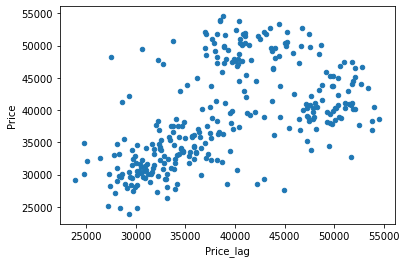

In [38]:
# 추가한 변수들과 Target과의 관계를 차트로 살펴봅시다.
g_price_new_1.plot(kind = "scatter", x= "Price_lag", y= "Price")



<AxesSubplot:xlabel='in_ton_lag', ylabel='Price'>

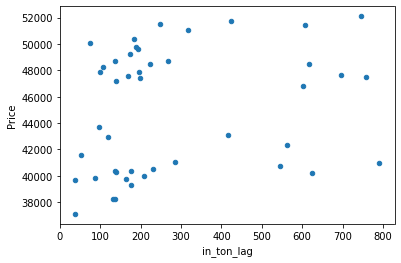

In [39]:
# 추가한 변수들과 Target과의 관계를 차트로 살펴봅시다.
g_price_new_1.plot(kind = "scatter", x= "in_ton_lag", y= "Price")



<AxesSubplot:xlabel='Unit_Price', ylabel='Price'>

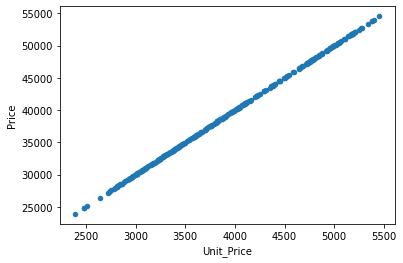

In [40]:
# 추가한 변수들과 Target과의 관계를 차트로 살펴봅시다.
g_price_new_1.plot(kind = "scatter", x= "Unit_Price", y= "Price")



<AxesSubplot:xlabel='Unit_Price_lag', ylabel='Price'>

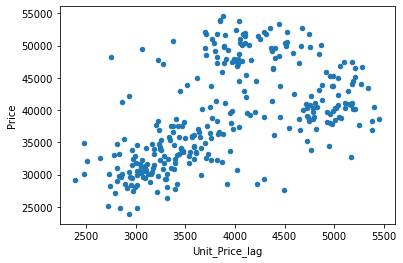

In [45]:
# 추가한 변수들과 Target과의 관계를 차트로 살펴봅시다.
g_price_new_1.plot(kind = "scatter", x= "Unit_Price_lag", y= "Price")



<AxesSubplot:xlabel='Unit_Price_MA_3_lag', ylabel='Price'>

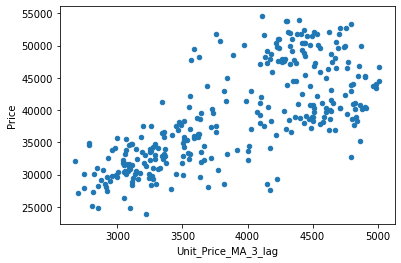

In [46]:
# 추가한 변수들과 Target과의 관계를 차트로 살펴봅시다.
g_price_new_1.plot(kind = "scatter", x= "Unit_Price_MA_3_lag", y= "Price")



## 20.데이터 준비

### 21.변수 정리

In [47]:
g_price_new_1.head()

,Date,Price,KG,in_ton,Unit_Price,WeekDay,Price_lag,in_ton_lag,Price_diff,in_ton_diff,Price_MA_3_lag,in_ton_MA_3_lag,Unit_Price_lag,Unit_Price_MA_3_lag
0,2019-01-03,44450,10,616.0,4445.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2019-01-04,48447,10,415.0,4844.7,4,44450.0,616.0,NaN,NaN,44450.000000,616.000000,4445.0,4445.000000
70,2019-01-05,43085,10,423.0,4308.5,5,48447.0,415.0,3997.0,-201.0,46448.500000,515.500000,4844.7,4644.850000
105,2019-01-07,51744,10,759.0,5174.4,0,43085.0,423.0,-5362.0,8.0,45327.333333,484.666667,4308.5,4532.733333
140,2019-01-08,47523,10,189.0,4752.3,1,51744.0,759.0,8659.0,336.0,47758.666667,532.333333,5174.4,4775.866667


In [67]:
# 날짜 변수는 제거합니다.
#날짜, Unit_Price, Price_lag, in_ton_lag, WeekDay
g_price_new_1 = g_price_new_1.drop(['Date', 'KG', 'in_ton', 'in_ton_diff', 'in_ton_MA_3_lag'], axis=1)


In [68]:
# 날짜 변수는 제거합니다.
#날짜, Unit_Price, Price_lag, in_ton_lag, WeekDay
g_price_new_1 = g_price_new_1.drop(['in_ton_lag'], axis=1)
g_price_new_1

,Price,Unit_Price,WeekDay,Price_lag,Price_diff,Price_MA_3_lag,Unit_Price_lag,Unit_Price_MA_3_lag
0,44450,4445.0,3,NaN,NaN,NaN,NaN,NaN
35,48447,4844.7,4,44450.0,NaN,44450.000000,4445.0,4445.000000
70,43085,4308.5,5,48447.0,3997.0,46448.500000,4844.7,4644.850000
105,51744,5174.4,0,43085.0,-5362.0,45327.333333,4308.5,4532.733333
140,47523,4752.3,1,51744.0,8659.0,47758.666667,5174.4,4775.866667
...,...,...,...,...,...,...,...,...
10831,33944,3394.4,3,32451.0,2736.0,31462.666667,3245.1,3146.266667
10870,31748,3174.8,4,33944.0,1493.0,32036.666667,3394.4,3203.666667
10909,30950,3095.0,5,31748.0,-2196.0,32714.333333,3174.8,3271.433333
10948,31256,3125.6,0,30950.0,-798.0,32214.000000,3095.0,3221.400000


### 22.NA 처리
(아래에서 knn imputation으로 처리할 겁입니다.)

### 24.Dummy Variable

* 요일은 범주입니다. 가변수화를 수행하시오.
* 가변수화 이후 불필요한 Feature를 제거합시다.
* 주의!, 성능은 어떤 Feature를 넣느냐에 따라 달라집니다.   
* Feature가 많다고 성능이 꼭 개선되는 것은 아닙니다.

In [69]:
data_wd = pd.get_dummies(g_price_new_1['WeekDay'], prefix = 'W', drop_first = 1)
data_wd.head()

,W_1,W_2,W_3,W_4,W_5
0,0,0,1,0,0
35,0,0,0,1,0
70,0,0,0,0,1
105,0,0,0,0,0
140,1,0,0,0,0


In [70]:
g_price_new_2 = pd.concat([g_price_new_1, data_wd], axis=1)
g_price_new_2.head()

,Price,Unit_Price,WeekDay,Price_lag,Price_diff,Price_MA_3_lag,Unit_Price_lag,Unit_Price_MA_3_lag,W_1,W_2,W_3,W_4,W_5
0,44450,4445.0,3,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
35,48447,4844.7,4,44450.0,NaN,44450.000000,4445.0,4445.000000,0,0,0,1,0
70,43085,4308.5,5,48447.0,3997.0,46448.500000,4844.7,4644.850000,0,0,0,0,1
105,51744,5174.4,0,43085.0,-5362.0,45327.333333,4308.5,4532.733333,0,0,0,0,0
140,47523,4752.3,1,51744.0,8659.0,47758.666667,5174.4,4775.866667,1,0,0,0,0


In [71]:
g_price_new_2 = g_price_new_2.drop(['WeekDay'], axis=1)
g_price_new_2

,Price,Unit_Price,Price_lag,Price_diff,Price_MA_3_lag,Unit_Price_lag,Unit_Price_MA_3_lag,W_1,W_2,W_3,W_4,W_5
0,44450,4445.0,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
35,48447,4844.7,44450.0,NaN,44450.000000,4445.0,4445.000000,0,0,0,1,0
70,43085,4308.5,48447.0,3997.0,46448.500000,4844.7,4644.850000,0,0,0,0,1
105,51744,5174.4,43085.0,-5362.0,45327.333333,4308.5,4532.733333,0,0,0,0,0
140,47523,4752.3,51744.0,8659.0,47758.666667,5174.4,4775.866667,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10831,33944,3394.4,32451.0,2736.0,31462.666667,3245.1,3146.266667,0,0,1,0,0
10870,31748,3174.8,33944.0,1493.0,32036.666667,3394.4,3203.666667,0,0,0,1,0
10909,30950,3095.0,31748.0,-2196.0,32714.333333,3174.8,3271.433333,0,0,0,0,1
10948,31256,3125.6,30950.0,-798.0,32214.000000,3095.0,3221.400000,0,0,0,0,0


### 25.Data Split

train : test = 7 : 3으로 분할합니다.

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X = g_price_new_2.drop('Price', axis=1)# == data.iloc[:, 1:]
y = g_price_new_2.iloc[:, 0]

In [88]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

### (Again)22.NA 처리 : knn Imputation
전날 데이터를 끌어오는 작업으로 인해 NaN이 생겨 있을 것입니다.  
Knn Imputation으로 채웁시다.

In [89]:
# 필요한 함수 불러오기
from sklearn.impute import KNNImputer

# 선언한다.
imputer = KNNImputer()

# 함수를 만든다.
imputer.fit(train_x)

# 적용한다.
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

### 26.Scaling features




In [90]:
from sklearn.preprocessing import MinMaxScaler

In [91]:
# 함수 선언
scaler = MinMaxScaler()

# 함수 만들기
scaler.fit(train_x)

MinMaxScaler()

In [92]:
# 함수 적용하기
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

### 27.Dataframe to Numpy array

## 30.모델링

* 알고리즘은 선형회귀, knn 둘중 무엇을 사용해도 좋습니다.
* 성능은 알고리즘, Feature 종류에 달려 있습니다. 24.에서 불필요한 변수 제거하는 부분에서 Feature를 정리할 수 있습니다.
* 모델링 평가 결과 RMSE 값을 구글 시트에 올려 봅시다.
* 1등에게는 스벅 커피 쿠폰 쏩니다.^^

In [93]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [94]:


model_lm = LinearRegression()
model_lm.fit(train_x, train_y)
test_pred_lm = model_lm.predict(test_x)
print(mean_squared_error(test_y, test_pred_lm, squared=0))

9.905090283469447e-12


In [95]:
for k in range(3, 21):
    model_knn_n = KNeighborsRegressor(n_neighbors=k)
    model_knn_n.fit(train_x, train_y)
    test_pred_knn_n = model_knn_n.predict(test_x)
    print('k:{}, RMSE : {}'.format(k, mean_squared_error(test_y, test_pred_knn_n, squared=0)))

k:3, RMSE : 2721.615527977014
k:4, RMSE : 2974.636254137529
k:5, RMSE : 3146.995996322456
k:6, RMSE : 3120.3966062140985
k:7, RMSE : 3277.6275934438236
k:8, RMSE : 3332.8690672241405
k:9, RMSE : 3450.6347216349113
k:10, RMSE : 3488.9724800620647
k:11, RMSE : 3579.7523764648313
k:12, RMSE : 3675.889147126934
k:13, RMSE : 3750.432646982869
k:14, RMSE : 3844.7932329455393
k:15, RMSE : 3933.962666381455
k:16, RMSE : 3956.9346670849654
k:17, RMSE : 4142.266243115611
k:18, RMSE : 4256.099027568296
k:19, RMSE : 4354.945660746795
k:20, RMSE : 4485.218391573447


# 여러분 정말 수고 많으셨습니다!